# Kaggle Example

https://www.kaggle.com/mirichoi0218/insurance

We will use this dataset to try to predict the charges.


In [146]:
#Import sklearn before tensorflow
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


In [147]:
print(tf.__version__), sys.version, sklearn.show_versions()

2.4.1

System:
    python: 3.7.3 (default, Jan 22 2021, 20:04:44)  [GCC 8.3.0]
executable: /usr/bin/python3
   machine: Linux-5.10.17-v8+-aarch64-with-debian-10.9

Python dependencies:
          pip: 21.0.1
   setuptools: 54.1.2
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.1
       Cython: 0.29.22
       pandas: 1.2.3
   matplotlib: 3.3.4
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True


(None, '3.7.3 (default, Jan 22 2021, 20:04:44) \n[GCC 8.3.0]', None)

In [148]:
# Build a plotting function to visualize our results
def plot_predictions (train_data, # = X_train,
                      train_labels, # = y_train,
                      test_data, # = X_test,
                      test_labels, # = y_test,
                      predictions):
    """
    Plots training data, test data, and compares predictions to ground truth labels.
    """
    plt.figure(figsize=(10,7))
    #Plot trainging data in blue
    plt.scatter(train_data, train_labels, c="b", label="Training Data")
    # Plot testing data in green
    plt.scatter(test_data, test_labels, c="g", label="Testing Data")
    # Plot models predictions in red
    plt.scatter(test_data, predictions, c="r", label="Predictions")
    # Show the legend
    plt.legend()

# Make some functions to reuse MAE and MSE
def mae(y_true, y_pred):
    return tf.metrics.mean_absolute_error(y_true = y_true, y_pred = tf.squeeze(y_pred)).numpy()

def mse(y_true, y_pred):
    return tf.metrics.mean_squared_error(y_true = y_true, y_pred = tf.squeeze(y_pred)).numpy()

In [149]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Get Data

In [150]:
# Read in the insurance dataset
insurance = pd.read_csv(
    "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
)

insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [151]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

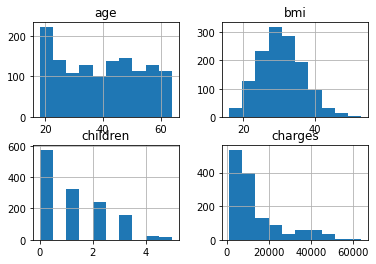

In [152]:
insurance.hist()

In [153]:
# One hot encode the categorical variables so they are all numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.reset_index(drop=True, inplace=True)
insurance_one_hot.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [154]:
# Create X and y variables (features and labels)
# Create training and test sets
X = insurance_one_hot.drop(['charges'], axis=1)
y = insurance_one_hot["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, y_train, len(X), len(X_train), len(X_test)


(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 560    46  19.950         2           1         0          1           0   
 1285   47  24.320         0           1         0          1           0   
 1142   52  24.860         0           1         0          1           0   
 969    39  34.320         5           1         0          1           0   
 486    54  21.470         3           1         0          1           0   
 ...   ...     ...       ...         ...       ...        ...         ...   
 1095   18  31.350         4           1         0          1           0   
 1130   39  23.870         5           1         0          1           0   
 1294   58  25.175         0           0         1          1           0   
 860    37  47.600         2           1         0          0           1   
 1126   55  29.900         0           0         1          1           0   
 
       region_northeast  region_northwest  region_southeast  region_southw

# insurance_model_1 - First training pass

In [155]:
# 1. Build model
insurance_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)    
])

# 2. Compile model
insurance_model_1.compile (
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.mae, tf.keras.metrics.mse]
)

# 3. Fit model
insurance_model_1.fit(X_train, y_train, epochs = 100)

Epoch 1/100
34/34 [==============================] - 2s 3ms/step - loss: 10200.7270 - mean_absolute_error: 10200.7270 - mean_squared_error: 232906844.3429
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 7718.1925 - mean_absolute_error: 7718.1925 - mean_squared_error: 166405425.8286
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 6983.7826 - mean_absolute_error: 6983.7826 - mean_squared_error: 144605303.0857
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 8083.4822 - mean_absolute_error: 8083.4822 - mean_squared_error: 186700500.5714
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 7793.8446 - mean_absolute_error: 7793.8446 - mean_squared_error: 165165009.3714
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 7618.4116 - mean_absolute_error: 7618.4116 - mean_squared_error: 167119723.6571
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 7678.49

In [156]:
# Check the results of the insurance model on the test data
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 7023.3296 - mean_absolute_error: 7023.3296 - mean_squared_error: 111577832.0000


[7023.32958984375, 7023.32958984375, 111577832.0]

In [157]:
# Make and plot predictions for model_1
y_preds_1 = insurance_model_1.predict(X_test)
#Our average cost is 13346, and our overage error is 7023. So the model is very inaccurate
y_train.mean(), mae(y_test, y_preds_1), mse(y_test, y_preds_1)

(13346.089736364485, 7023.33, 111577830.0)

# insurance_model_2 - Try to improve the model

Change hidden layers and optimizer

In [158]:
# 1. Build model
insurance_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)    
])

# 2. Compile model
insurance_model_2.compile (
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.mae, tf.keras.metrics.mse]
)

# 3. Fit model
insurance_model_2.fit(X_train, y_train, epochs = 100, verbose = 0)

In [159]:
# Evaluate the model
y_preds_2 = insurance_model_2.predict(X_test)
#Our average cost is 13346, and our overage error is 7023. So the model is very inaccurate
y_train.mean(), mae(y_test, y_preds_2), mse(y_test, y_preds_2)

(13346.089736364485, 4853.852, 97747416.0)

# insurance_model_3 - Further improve the model

Train for longer

In [160]:
# 1. Build model
insurance_model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)    
])

# 2. Compile model
insurance_model_3.compile (
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.mae] #, tf.keras.metrics.mse]
)

# 3. Fit model
history = insurance_model_3.fit(X_train, y_train, epochs = 300, verbose = 0)

In [161]:
# Evaluate the model
y_preds_3 = insurance_model_3.predict(X_test)
#Our average cost is 13346, and our overage error is 7023. So the model is very inaccurate
y_train.mean(), mae(y_test, y_preds_3), mse(y_test, y_preds_3)

(13346.089736364485, 3230.5403, 38610880.0)

Text(0.5, 0, 'epochs')

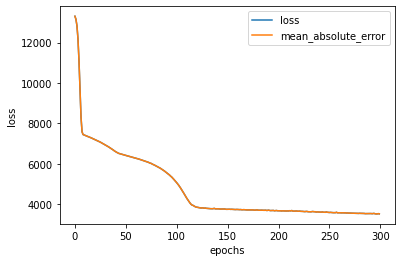

In [162]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

# Preprocessing Data (normalization and standardization)

In terms of scaling values, neural networks tend to prefer normalization (as opposed to standardization).

If youre not sure of which to use, you could try both and see which performs better.


<AxesSubplot:ylabel='Frequency'>

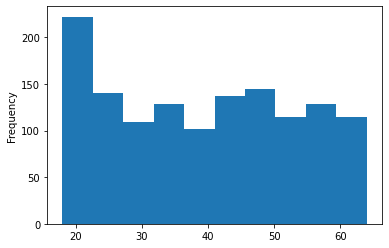

In [163]:
X["age"].plot(kind="hist")

In [164]:
X["children"].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [165]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # turn all values in these columns to be between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

X = insurance.drop("charges", axis = 1)
y = insurance["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the column transformer to our training data
ct.fit(X_train)

# Transfortm training and test data with nmormalization (MinMaxScaler) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [166]:
# What does our data look like now?
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

In [170]:
# Now that the data has been normalized and one hot encoded, build a neural network model
# 1. Build the model
insurance_model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
insurance_model_4.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.mae]
)

# 3. Fit the model
history = insurance_model_4.fit(X_train_normal, y_train, epochs = 100)

s/step - loss: 3705.1190 - mean_absolute_error: 3705.1190
Epoch 332/500
34/34 [==============================] - 0s 4ms/step - loss: 3383.7073 - mean_absolute_error: 3383.7073
Epoch 333/500
34/34 [==============================] - 0s 4ms/step - loss: 3422.2709 - mean_absolute_error: 3422.2709
Epoch 334/500
34/34 [==============================] - 0s 4ms/step - loss: 3455.9071 - mean_absolute_error: 3455.9071
Epoch 335/500
34/34 [==============================] - 0s 4ms/step - loss: 3292.8007 - mean_absolute_error: 3292.8007
Epoch 336/500
34/34 [==============================] - 0s 3ms/step - loss: 3276.1673 - mean_absolute_error: 3276.1673
Epoch 337/500
34/34 [==============================] - 0s 4ms/step - loss: 3713.4364 - mean_absolute_error: 3713.4364
Epoch 338/500
34/34 [==============================] - 0s 4ms/step - loss: 3655.8888 - mean_absolute_error: 3655.8888
Epoch 339/500
34/34 [==============================] - 0s 4ms/step - loss: 3410.8722 - mean_absolute_error: 3410.872

In [171]:
# Evaluate our insurance model trained on normalized data
insurance_model_4.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 3160.9441 - mean_absolute_error: 3160.9441


[3160.944091796875, 3160.944091796875]

Text(0.5, 0, 'epochs')

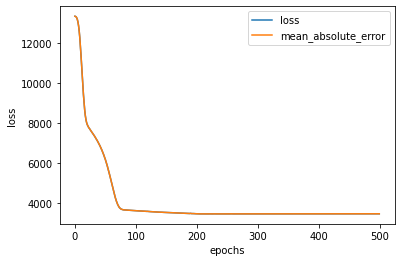

In [172]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")